In [73]:
# import all libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import math

In [2]:
# load csv
base_df = pd.read_csv('C:/CMI-DataScience-Project/atp_transformed/2000-2024 players_3.csv')

C:\Users\Golbe\AppData\Local\Temp\ipykernel_32588\4063985396.py:2: DtypeWarning: Columns (18,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  base_df = pd.read_csv('C:/CMI-DataScience-Project/atp_transformed/2000-2024 players_3.csv')


In [3]:
# In case you do not know the id associated with a player you can insert a full name or part of a name in this lookup tool
player_name = 'Roger Federer'

base_df[['player_name','player_id','player_country','tourney_name','tourney_date','player_rank','elo']][base_df['player_name'].str.contains(player_name)]

,player_name,player_id,player_country,tourney_name,tourney_date,player_rank,elo
223422,Roger Federer,103819,SUI,Basel,1999-10-04,106.0,1511.603702
223423,Roger Federer,103819,SUI,Adelaide,2000-01-03,64.0,1527.715787
223424,Roger Federer,103819,SUI,Adelaide,2000-01-03,64.0,1512.046412
223425,Roger Federer,103819,SUI,Auckland,2000-01-10,61.0,1495.491876
223426,Roger Federer,103819,SUI,Australian Open,2000-01-17,62.0,1515.640714
...,...,...,...,...,...,...,...
224909,Roger Federer,103819,SUI,Wimbledon,2021-06-28,8.0,2575.355833
224910,Roger Federer,103819,SUI,Wimbledon,2021-06-28,8.0,2579.039516
224911,Roger Federer,103819,SUI,Wimbledon,2021-06-28,8.0,2588.284246
224912,Roger Federer,103819,SUI,Wimbledon,2021-06-28,8.0,2594.342819


## IMPORTANT!!!
DISABLE THE PLAYER HERE. IF NO PLAYER_ID IS PASSED IT WILL USE THE WHOLE DATASET

In [88]:
# put the player id and years of experience of the player you want to look up here
excluded_player = 103819
less_than_years = 7

only_players = base_df[['player_name','player_id']]
only_players = only_players.drop_duplicates()
name_chosen_player = only_players['player_name'][only_players['player_id'] == excluded_player].iloc[0]

## Rest of normal flow

In [5]:
# extra assignment to reset dataframe if a mistake is made during processing
full_df = base_df.copy()
len(full_df)

1282807

In [25]:
selected_features = [
'player_id', # needed to know what player to keep or drop
# 'surface', 
'tourney_level', 
# 'tourney_date', # dropped because not numeric 
'match_num', 
#'player_height', 
# 'player_country', 
'player_age', 
# 'elo_pre_match', # derrived target
# 'opponent_elo_pre_match', 
#'opponent_rank', 
# 'mean_numb', # dropped as the rolling means are derrivitives of these columns and adding the raw ones creates a worse model and increases conlinearity
# 'median_numb', 
# 'total_numb', 
# 'mean_diff', 
# 'median_diff', 
# 'total_diff', 
# 'mean_tb_numb', 
# 'median_tb_numb', 
# 'total_tb_numb', 
# 'mean_tb_diff', 
# 'median_tb_diff', 
# 'total_tb_diff', 
'days_of_experience',
# 'career_year', 
# 'rest_days', 
# 'set_dominance', 
# 'tb_dominance', 
#'highest_finish_position', 
'draw_size_rolling_med_10', 
'highest_finish_position_rolling_med_10', 
# 'ace_rolling_mean_10', 
# 'double_faults_rolling_mean_10', # drop these so that most low level players are included
# 'points_on_serve_rolling_mean_10', 
# 'first_serve_in_rolling_mean_10', 
# '1stWon_rolling_mean_10', 
# '2ndWon_rolling_mean_10', 
# 'service_games_rolling_mean_10', 
# 'break_points_saved_rolling_mean_10', 
# 'break_points_faced_rolling_mean_10', 
# 'elo_pre_match_rolling_mean_10',
# 'opponent_elo_pre_match_rolling_mean_10', 
'set_dominance_rolling_mean_10', 
'tb_dominance_rolling_mean_10', 
#'player_rank_rolling_mean_10', # dropped because the model will cheat with this if predicting rank
'mean_numb_rolling_mean_10', 
#'median_numb_rolling_mean_10', 
#'total_numb_rolling_mean_10', 
'mean_diff_rolling_mean_10', 
#'median_diff_rolling_mean_10', 
#'total_diff_rolling_mean_10', 
'mean_tb_numb_rolling_mean_10', 
#'median_tb_numb_rolling_mean_10', 
#'total_tb_numb_rolling_mean_10', 
'mean_tb_diff_rolling_mean_10', 
#'median_tb_diff_rolling_mean_10', 
#'total_tb_diff_rolling_mean_10', 
# 'elo', # This is the elo after the match has concluded and is the same as elo post match
'binned_elo' # target
]

In [7]:
print(full_df.shape)

(1282807, 132)


replace all nan values with 0

In [8]:
full_df[['median_tb_diff','mean_tb_numb','median_tb_numb','mean_tb_diff','tb_dominance',
         'draw_size_rolling_med_10', 'highest_finish_position_rolling_med_10', 'ace_rolling_mean_10', 
        'double_faults_rolling_mean_10', 'points_on_serve_rolling_mean_10', 'first_serve_in_rolling_mean_10',
        '1stWon_rolling_mean_10', '2ndWon_rolling_mean_10', 'service_games_rolling_mean_10', 'break_points_saved_rolling_mean_10',
        'break_points_faced_rolling_mean_10','elo_pre_match_rolling_mean_10','opponent_elo_pre_match_rolling_mean_10', 
        'set_dominance_rolling_mean_10','tb_dominance_rolling_mean_10','player_rank_rolling_mean_10', 'mean_numb_rolling_mean_10', 
        'median_numb_rolling_mean_10','total_numb_rolling_mean_10','mean_diff_rolling_mean_10','median_diff_rolling_mean_10', 
        'total_diff_rolling_mean_10','mean_tb_numb_rolling_mean_10','median_tb_numb_rolling_mean_10','total_tb_numb_rolling_mean_10', 
        'mean_tb_diff_rolling_mean_10','median_tb_diff_rolling_mean_10','total_tb_diff_rolling_mean_10']] = full_df[['median_tb_diff','mean_tb_numb','median_tb_numb','mean_tb_diff','tb_dominance','draw_size_rolling_med_10', 'highest_finish_position_rolling_med_10', 'ace_rolling_mean_10', 
        'double_faults_rolling_mean_10', 'points_on_serve_rolling_mean_10', 'first_serve_in_rolling_mean_10',
        '1stWon_rolling_mean_10', '2ndWon_rolling_mean_10', 'service_games_rolling_mean_10', 'break_points_saved_rolling_mean_10',
        'break_points_faced_rolling_mean_10','elo_pre_match_rolling_mean_10','opponent_elo_pre_match_rolling_mean_10', 
        'set_dominance_rolling_mean_10','tb_dominance_rolling_mean_10','player_rank_rolling_mean_10', 'mean_numb_rolling_mean_10', 
        'median_numb_rolling_mean_10','total_numb_rolling_mean_10','mean_diff_rolling_mean_10','median_diff_rolling_mean_10', 
        'total_diff_rolling_mean_10','mean_tb_numb_rolling_mean_10','median_tb_numb_rolling_mean_10','total_tb_numb_rolling_mean_10', 
        'mean_tb_diff_rolling_mean_10','median_tb_diff_rolling_mean_10','total_tb_diff_rolling_mean_10']].replace(np.nan,0)

In [9]:
# fill missing elo with baseline as that is where everything starts
print(full_df['elo'].isna().sum())
full_df['elo'] = full_df['elo'].replace(np.nan,1500)
print(full_df['elo'].isna().sum())

# also make one without nan values to compare
print(base_df['elo'].isna().sum())
full_df_2 = base_df[base_df['elo'].notna()]
print(full_df_2['elo'].isna().sum())

19267
0
19267
0


Create the max player elo and join to full_df as best elo reached

In [10]:
best_elo_filled = full_df.groupby('player_id', as_index=False)['elo'].max()
best_elo_filled = best_elo_filled.rename(columns={'elo':'best_elo_reached'})

full_df = pd.merge(left=full_df,right=best_elo_filled,how='left',on='player_id')

best_elo_dropped = full_df_2.groupby('player_id', as_index=False)['elo'].max()
best_elo_dropped = best_elo_dropped.rename(columns={'elo':'best_elo_reached'})

full_df_2 = pd.merge(left=full_df_2,right=best_elo_dropped,how='left',on='player_id')

## Binning logic

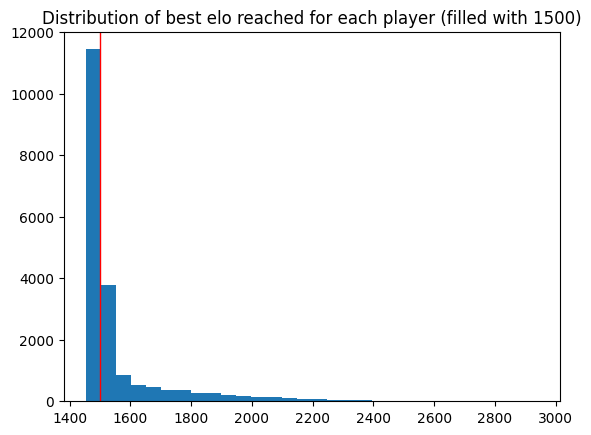

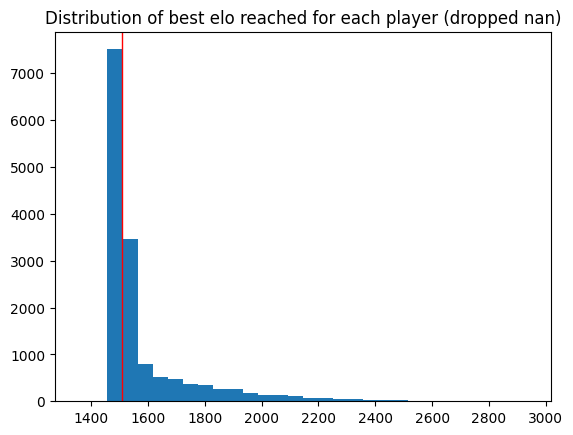

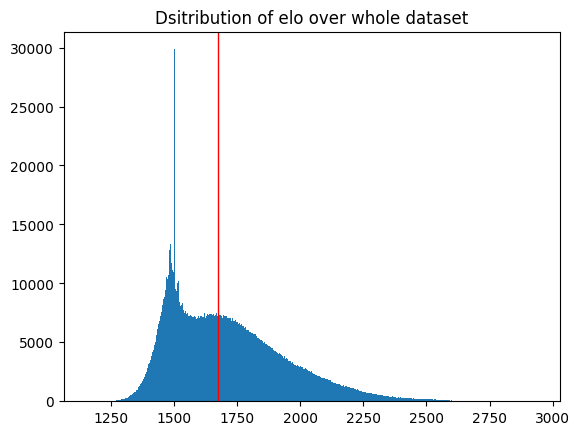

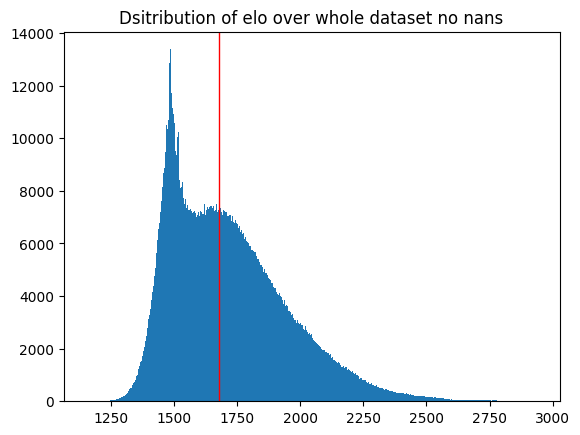

,full_df (filled NaN),full_df_2 (no NaN),population_difference,best_elo (filled NaN),best_elo (no NaN),best_elo_difference
count,1.282807e+06,1.263540e+06,-19267.0000,19398.0000,14939.0000,-4459.0000
mean,1.711800e+03,1.715030e+03,3.2296,1567.7724,1582.4237,14.6513
std,2.341727e+02,2.344751e+02,0.3024,157.8665,177.8213,19.9547
min,1.150759e+03,1.150759e+03,0.0000,1454.3067,1351.5832,-102.7235
25%,1.517139e+03,1.523177e+03,6.0382,1500.0000,1487.7629,-12.2371
50%,1.671911e+03,1.676642e+03,4.7310,1500.0000,1509.8458,9.8458
75%,1.850411e+03,1.853898e+03,3.4874,1531.8420,1574.5312,42.6892
max,2.938310e+03,2.938310e+03,0.0000,2938.3098,2938.3098,0.0000


In [11]:
# histogram of the target var (very skewed because the minimum highest rank is 1500. It could be argued that the max ranks should only be all players who quit early stop at 1500 or lower)
plt.title("Distribution of best elo reached for each player (filled with 1500)")
plt.hist(best_elo_filled['best_elo_reached'],bins=30)
plt.axvline(np.quantile(best_elo_filled['best_elo_reached'],0.5),color='red',linewidth=1)
plt.show()

plt.title("Distribution of best elo reached for each player (dropped nan)")
plt.hist(best_elo_dropped['best_elo_reached'],bins=30)
plt.axvline(np.quantile(best_elo_dropped['best_elo_reached'],0.5),color='red',linewidth=1)
plt.show()

# histogram of the elo
plt.title("Dsitribution of elo over whole dataset")
plt.hist(full_df['elo'],bins=500)
plt.axvline(np.quantile(full_df['elo'],0.5),color='red',linewidth=1)
plt.show()

plt.title("Dsitribution of elo over whole dataset no nans")
plt.hist(full_df_2['elo'],bins=500)
plt.axvline(np.quantile(full_df_2['elo'],0.5),color='red',linewidth=1)
plt.show()

# make descriptve stats to show the difference is small when filling vs dropping for both populations and max rank feature
desc_filled = full_df['elo'].describe()
desc_dropped = full_df_2['elo'].describe()
desc_best_elo_filled = best_elo_filled['best_elo_reached'].describe()
desc_best_elo_dropped = best_elo_dropped['best_elo_reached'].describe()


# Combine into one DataFrame
summary_df = pd.DataFrame({
    'full_df (filled NaN)': round(desc_filled,4),
    'full_df_2 (no NaN)': round(desc_dropped,4),
    'population_difference':round(desc_dropped-desc_filled,4),
    'best_elo (filled NaN)': round(desc_best_elo_filled,4),
    'best_elo (no NaN)': round(desc_best_elo_dropped,4),
    'best_elo_difference': round(desc_best_elo_dropped-desc_best_elo_filled,4)
})
summary_df

This dataframe tells us that the difference between filling and dropping is small so for the sake of more samples we will fill with the base rank

Since this is a classifier model these ranks need to get binned. Less bins usually means better performance, but worse granuarity. It makes sense to do keep the bins somewhat limited and rank them based on the population.

We have already concluded that a 50% of the population is either near, at or below 1500 depending on filling nans or dropping them. Since we have chosen to fill, we will make a cutoff at 1500 and look at the population above this cutoff point. The simple solution is to just cut at 50%, 75%, 90%, 95% and maybe 99% but instead the cell below will create boundries based on the median of the dataset

19398


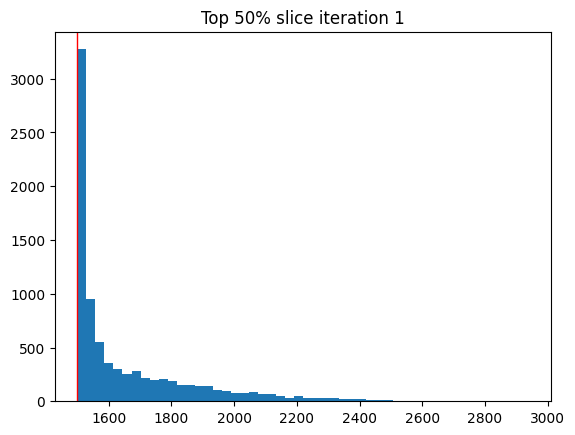

Iteration 1: 19398 rows before slicing, 8316 rows after slicing, sliced on median which was 1500.00, percentage of players left  after slicing = 0.429


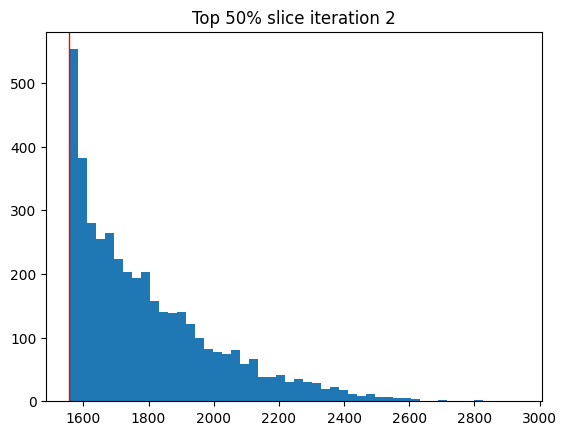

Iteration 2: 8316 rows before slicing, 4158 rows after slicing, sliced on median which was 1554.79, percentage of players left  after slicing = 0.214


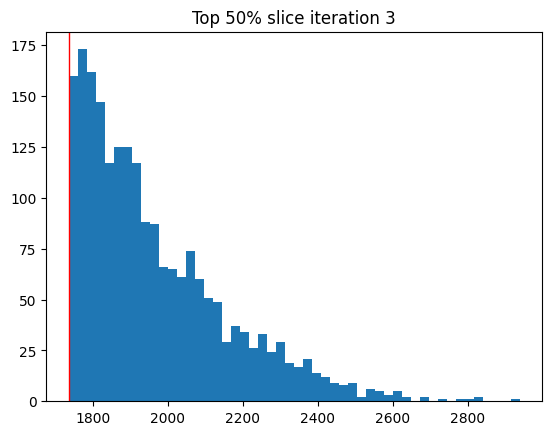

Iteration 3: 4158 rows before slicing, 2079 rows after slicing, sliced on median which was 1736.11, percentage of players left  after slicing = 0.107


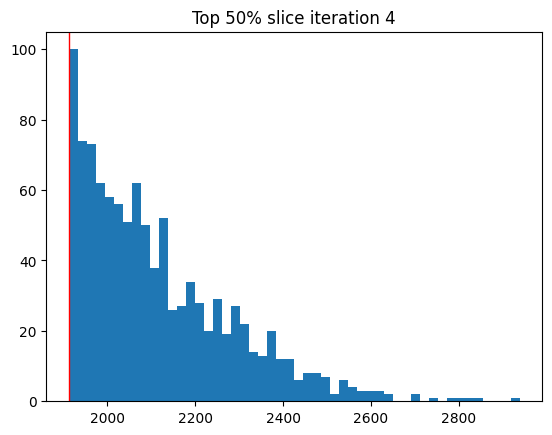

Iteration 4: 2079 rows before slicing, 1039 rows after slicing, sliced on median which was 1911.45, percentage of players left  after slicing = 0.054


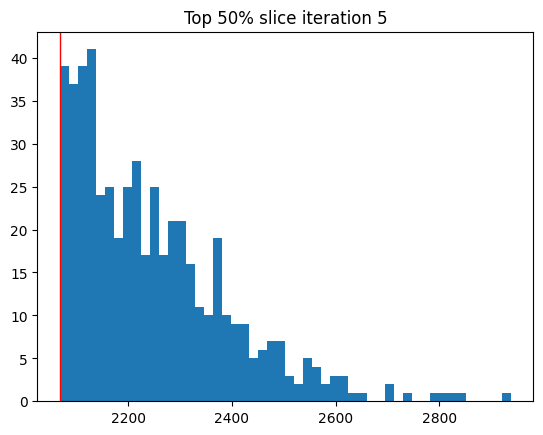

Iteration 5: 1039 rows before slicing, 519 rows after slicing, sliced on median which was 2067.60, percentage of players left  after slicing = 0.027


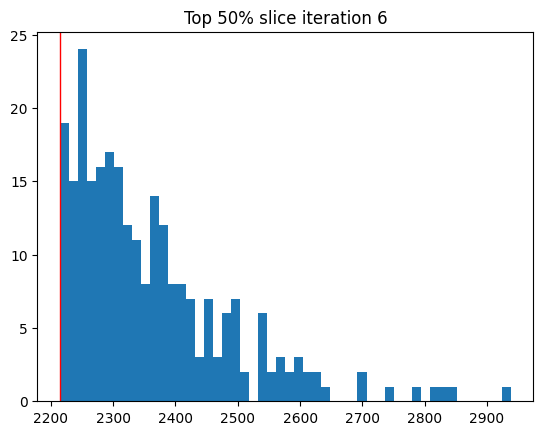

Iteration 6: 519 rows before slicing, 259 rows after slicing, sliced on median which was 2213.81, percentage of players left  after slicing = 0.013


In [12]:
# Start with the full dataset
subset = best_elo_filled.copy()
starting_rows = len(subset)
print(len(subset))

for i in range(1, 7):
    # median of current subset
    q = np.quantile(subset['best_elo_reached'], 0.5)
    rows_before_slice = len(subset)
    
    # cut top 50% 
    subset = subset[subset['best_elo_reached'] > q]
    
    plt.figure()
    plt.hist(subset['best_elo_reached'], bins=50)
    plt.axvline(q, color='red', linewidth=1)
    plt.title(f"Top 50% slice iteration {i}")
    plt.show()
    
    # Optional: print info
    print(f"Iteration {i}: {rows_before_slice} rows before slicing, {len(subset)} rows after slicing, sliced on median which was {q:.2f}, percentage of players left  after slicing = {round(len(subset)/starting_rows,3)}")

Bin the ranks based on ranges based on the previous medians per bin:
- 2067.6+:          top 2.7% | all time greats
- 2067.6-1911.45:    top 5.4% | very good players
- 1911.45-1736.11:   top 10.7% | good players
- 1736.11-1554.79:   top 21.4% |  mid tier players
- 1554.79-1500:      top 42.9% | younger pro's and weak players
- 1500-0:            bottom 57% | Very weak players

In [13]:
# bin the data using the previously established data rounded to the nearest integer value

bins = [0, 1500, 1555, 1736, 1911, 2068, 3500]
labels = [0, 1, 2, 3, 4, 5]

full_df['binned_elo'] = pd.cut(
    full_df['best_elo_reached'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

## Continue with normal pipeline

In [28]:
# select all features to use in the prediction
print(len(full_df))
df_subset = full_df[selected_features]
print(len(df_subset))

1282807
1282807


In [29]:
df_subset.isna().sum().sort_values(ascending=False)

player_id                                 0
tourney_level                             0
match_num                                 0
player_age                                0
days_of_experience                        0
draw_size_rolling_med_10                  0
highest_finish_position_rolling_med_10    0
set_dominance_rolling_mean_10             0
tb_dominance_rolling_mean_10              0
mean_numb_rolling_mean_10                 0
mean_diff_rolling_mean_10                 0
mean_tb_numb_rolling_mean_10              0
mean_tb_diff_rolling_mean_10              0
binned_elo                                0
dtype: int64

In [30]:
# drop all values where nan because knn cannot deal with empty values
df_subset = df_subset.dropna()

In [31]:
df_subset.isna().sum().sort_values(ascending=False)

player_id                                 0
tourney_level                             0
match_num                                 0
player_age                                0
days_of_experience                        0
draw_size_rolling_med_10                  0
highest_finish_position_rolling_med_10    0
set_dominance_rolling_mean_10             0
tb_dominance_rolling_mean_10              0
mean_numb_rolling_mean_10                 0
mean_diff_rolling_mean_10                 0
mean_tb_numb_rolling_mean_10              0
mean_tb_diff_rolling_mean_10              0
binned_elo                                0
dtype: int64

From testing, the categorical columns tend to add little value to the prediction besides tourney_level. Removing them creates a better model for all metrics

In [32]:
# # Print non numeric columns
print(len(df_subset))
numeric_cols = df_subset.select_dtypes(exclude=[np.number]).columns
print(numeric_cols)

# encode non numeric values
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid multicollinearity
surface_encoded = encoder.fit_transform(df_subset[[
    # 'surface',
    #'player_country',
    'tourney_level'
    ]])
surface_df = pd.DataFrame(surface_encoded, 
                          columns=encoder.get_feature_names_out([
    #'surface',
    #'player_country',
    'tourney_level'
                                                                 ]),
                          index=df_subset.index)
df_encoded = pd.concat([df_subset.drop([
    #'surface',
    #'player_country',
    'tourney_level'
    ], axis=1), surface_df], axis=1)
#df_encoded = df_subset
print(len(df_encoded))

1282807
Index(['tourney_level', 'binned_elo'], dtype='object')
1282807


## Remove the player that was specified from the train/test data using the player id column and drop that column

In [33]:
# remove the player from the dataset if id is specified
if excluded_player:
    # copy to not mess with the original df
    df_encoded_xp = df_encoded.copy()
    excluded_player_df = df_encoded_xp[df_encoded_xp.player_id == excluded_player]
    df_encoded = df_encoded_xp[df_encoded_xp.player_id != excluded_player]
    excluded_player_df = excluded_player_df.drop(columns='player_id')

# drop player_id regardless
df_encoded = df_encoded.drop(columns='player_id')

## Continue as normal

In [34]:
# make a subset of the data for finding the ideal amount of neighbors
df_subset = df_encoded.sample(frac=0.01, random_state=42)

In [35]:
# prepare data
X = df_encoded.drop('binned_elo', axis=1)  # Features
y = df_encoded['binned_elo']  # Target

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale features to normalise
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
# # select K and weights based on library
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.pipeline import Pipeline


# X_sub, _, y_sub, _ = train_test_split(
#     X_train,
#     y_train,
#     train_size=100_0,   # even 50k often sufficient
#     stratify=y_train,
#     random_state=42
# )

# pipe = Pipeline([
#     ('scaler', MinMaxScaler()),
#     ('knn', KNeighborsClassifier())
# ])

# param_grid = {
#     'knn__n_neighbors': list(range(1, 35))
# }

# grid = GridSearchCV(pipe, param_grid, cv=3, return_train_score=True,verbose=2,n_jobs=-1)
# grid.fit(X_sub, y_sub)

In [37]:
# # Extract k values
# k_values = param_grid['knn__n_neighbors']

# # Extract mean test scores and standard deviation from CV
# mean_test_scores = grid.cv_results_['mean_test_score']
# std_test_scores = grid.cv_results_['std_test_score']
# mean_train_scores = grid.cv_results_['mean_train_score']

# plt.figure(figsize=(10,6))
# plt.plot(k_values, mean_train_scores, label='Train Accuracy', marker='o',color='orangered')
# plt.plot(k_values, mean_test_scores, label='CV Accuracy', marker='o',color='seagreen')
# plt.xlabel("Number of Neighbors (k)")
# plt.ylabel("Accuracy")
# plt.title("KNN Train vs CV Accuracy")
# plt.legend()
# plt.show()

In [38]:
# train
k_number = 19
knn = KNeighborsClassifier(n_neighbors=k_number,weights='uniform')
knn.fit(X_train_scaled, y_train)

,n_neighbors,19
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [39]:
# predict
y_pred = knn.predict(X_test_scaled)

# metrics
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Check if there's overfitting
train_score = knn.score(X_train_scaled, y_train)
test_score = knn.score(X_test_scaled, y_test)
print(f"Train accuracy: {train_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")

Accuracy: 0.5163
Precision: 0.5114
Recall: 0.5163
F1 Score: 0.5108
Train accuracy: 0.5769
Test accuracy: 0.5163


In [40]:
bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
y_pred_str = [bin_labels[i] for i in y_pred]
y_test_str = [bin_labels[j] for j in y_test]

y_pred = pd.Series(y_pred)
results = X_test.reset_index(drop=True).copy()
results['true_elo_coded'] = y_test.reset_index(drop=True)
results['pred_elo_coded'] = y_pred
results['true_elo_coded'] = results['true_elo_coded'].astype(int)
results['pred_elo_coded'] = results['pred_elo_coded'].astype(int)
results['true_elo'] = y_test_str
results['pred_elo'] = y_pred_str
results['correct'] = results['true_elo'] == results['pred_elo']
results['number_of_bins_off'] = results['true_elo_coded'] - results['pred_elo_coded']

wrong_preds = results[results['correct'] == False]

len(wrong_preds)

123961

## Visualisations for whole dataset

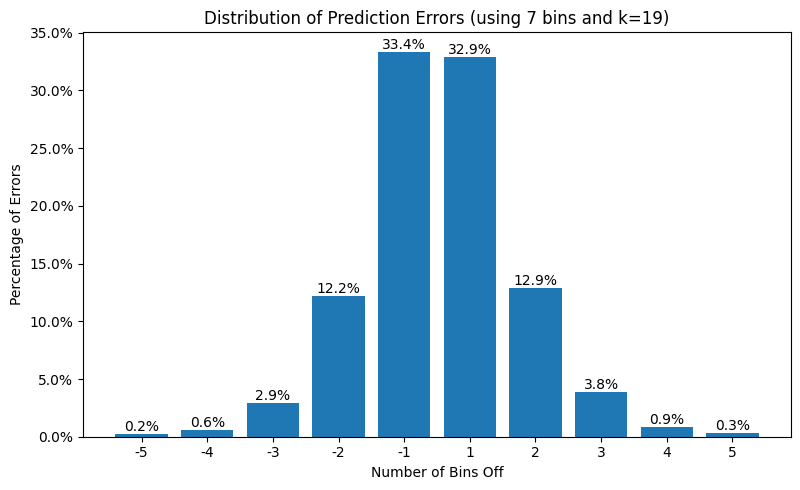

In [53]:
counts = wrong_preds['number_of_bins_off'].value_counts().sort_index()/len(wrong_preds)

plt.figure(figsize=(8,5))
plt.xlabel("Number of Bins Off")
plt.ylabel("Percentage of Errors")
plt.title(f"Distribution of Prediction Errors (using {len(bins)} bins and k={k_number})")
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
bars = plt.bar(counts.index.astype(str), counts.values)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1%}",
        ha="center",
        va="bottom"
    )
#plt.show()

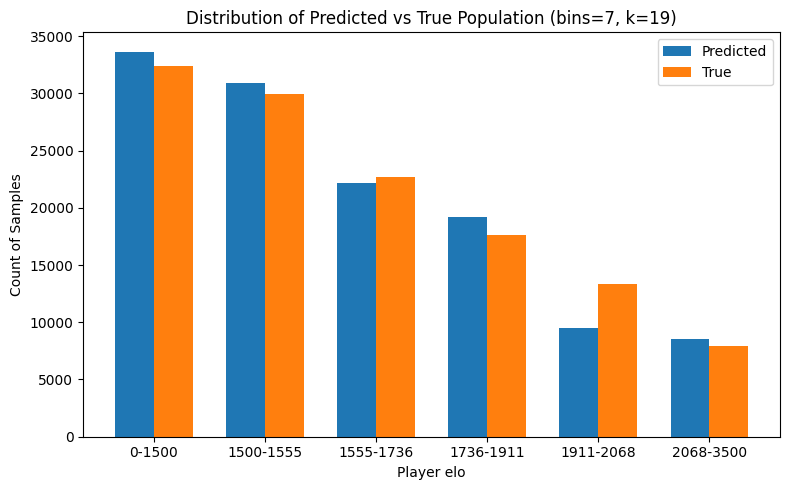

In [54]:
# distribution of pred player_ranks and true player_ranks
pred_counts = wrong_preds['pred_elo_coded'].value_counts()
true_counts = wrong_preds['true_elo_coded'].value_counts()

x = np.arange(len(pred_counts))  # the x locations
width = 0.35  # width of the bars

plt.figure(figsize=(8,5))
plt.bar(x - width/2, pred_counts.values, width=width, label='Predicted')
plt.bar(x + width/2, true_counts.values, width=width, label='True')

plt.xlabel("Player elo")
plt.ylabel("Count of Samples")
plt.title(f"Distribution of Predicted vs True Population (bins={len(bins)}, k={k_number})")
plt.xticks(x, bin_labels)
plt.legend()
plt.tight_layout()
plt.show()


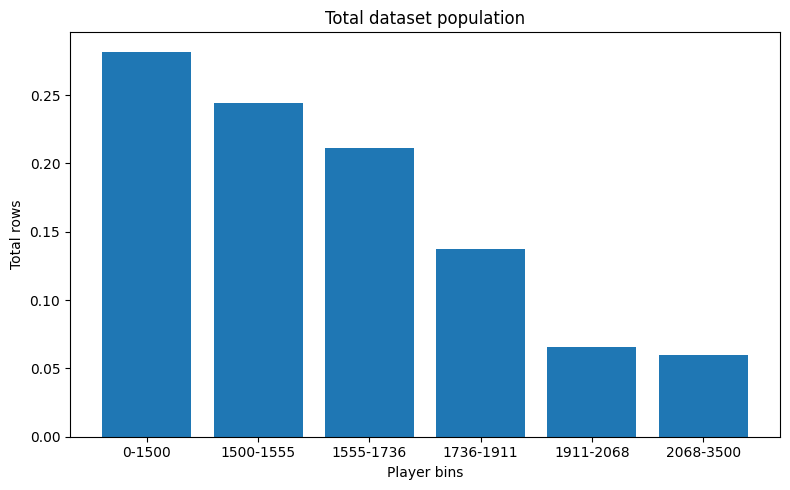

In [55]:
# Count occurrences of each binned rank
pred_counts = results['pred_elo_coded'].value_counts() / len(results)

x = np.arange(len(pred_counts))  # x positions
width = 0.8

plt.figure(figsize=(8,5))
plt.bar(x, pred_counts.values, width=width)

plt.xlabel("Player bins")
plt.ylabel("Total rows")
plt.title("Total dataset population")

# Use your string bin labels on the x-axis
plt.xticks(x, bin_labels)

plt.tight_layout()
plt.show()

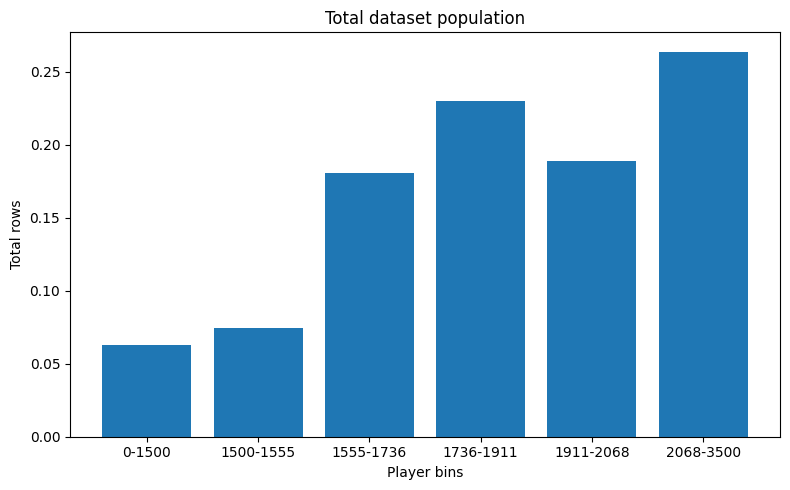

In [56]:
# Count occurrences of each binned rank
counts = df_encoded['binned_elo'].value_counts().sort_index() / len(df_encoded)

x = np.arange(len(counts))  # x positions
width = 0.8

plt.figure(figsize=(8,5))
plt.bar(x, counts.values, width=width)

plt.xlabel("Player bins")
plt.ylabel("Total rows")
plt.title("Total dataset population")

# Use your string bin labels on the x-axis
plt.xticks(x, bin_labels)

plt.tight_layout()
plt.show()

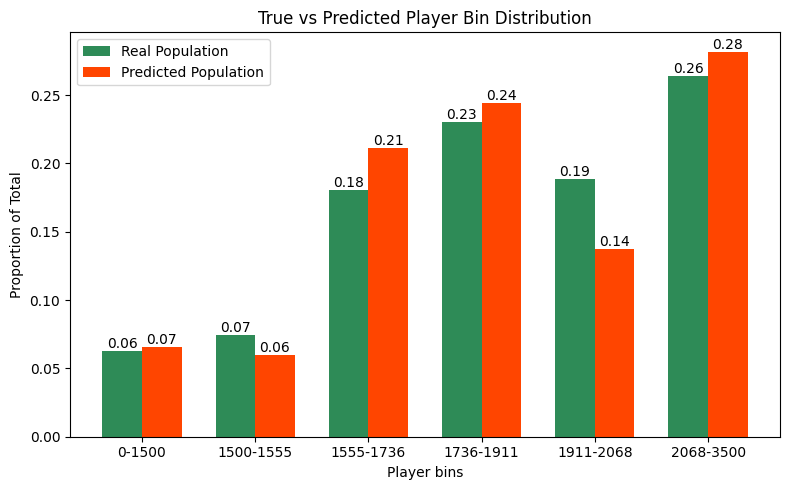

In [57]:
# True distribution
counts = df_encoded['binned_elo'].value_counts().sort_index() / len(df_encoded)

# Predicted distribution
pred_counts = results['pred_elo_coded'].value_counts().sort_index() / len(results)

x = np.arange(len(counts))  # x positions
width = 0.35  # width of bars

plt.figure(figsize=(8,5))
bars_true = plt.bar(x - width/2, counts.values, width=width, label='Real Population', color='seagreen')
bars_pred = plt.bar(x + width/2, pred_counts.values, width=width, label='Predicted Population', color='orangered')

plt.xlabel("Player bins")
plt.ylabel("Proportion of Total")
plt.title("True vs Predicted Player Bin Distribution")
plt.xticks(x, bin_labels)
plt.legend()
plt.tight_layout()

# Add labels on top of the bars
for bar in bars_true:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", ha='center', va='bottom')

for bar in bars_pred:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", ha='center', va='bottom')

plt.show()


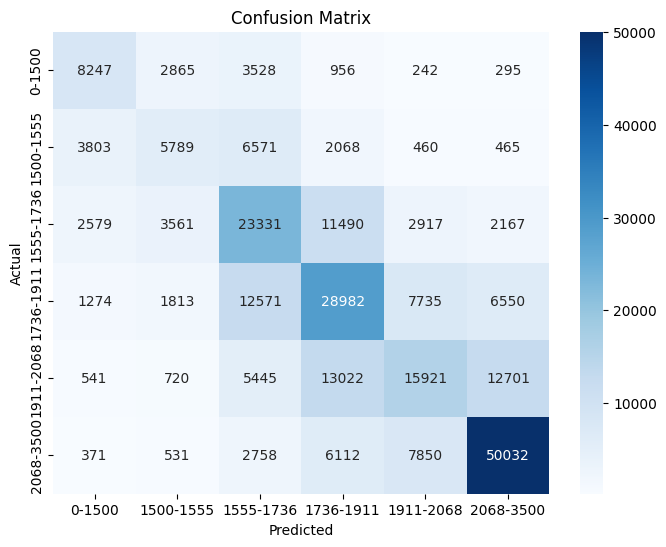

In [58]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=bin_labels,yticklabels=bin_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Validation and visualisation for the excluded player

In [47]:
if excluded_player:
    y_test_player_excluded = excluded_player_df['binned_elo']
    X_player_excluded = excluded_player_df.drop('binned_elo', axis=1)
    X_player_excluded_scaled = scaler.transform(X_player_excluded)
    y_pred_player_excluded = knn.predict(X_player_excluded_scaled)

else:
    print('player_id was empty')

Percentage of players correctly guessed for a particular player (Accuracy): 0.9953083109919572


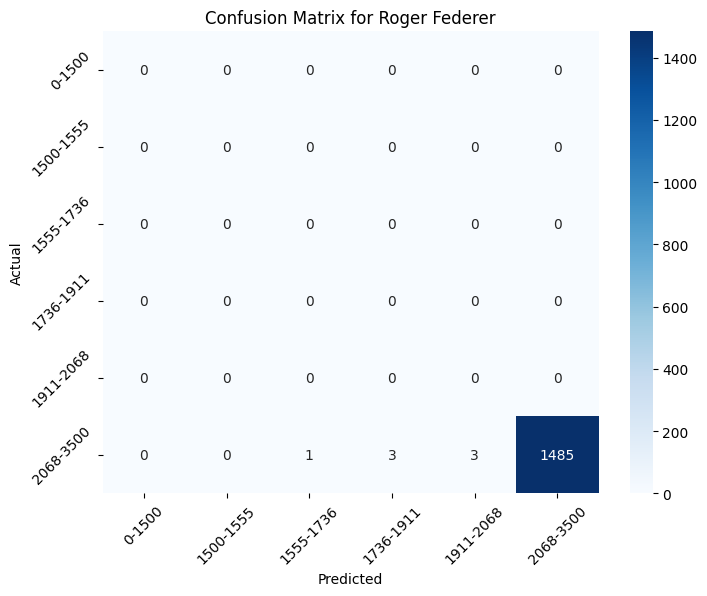

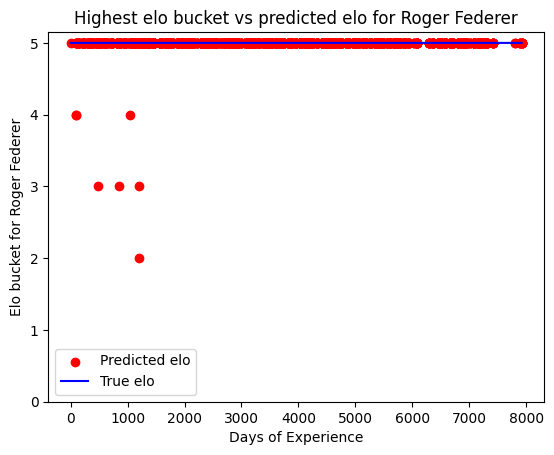

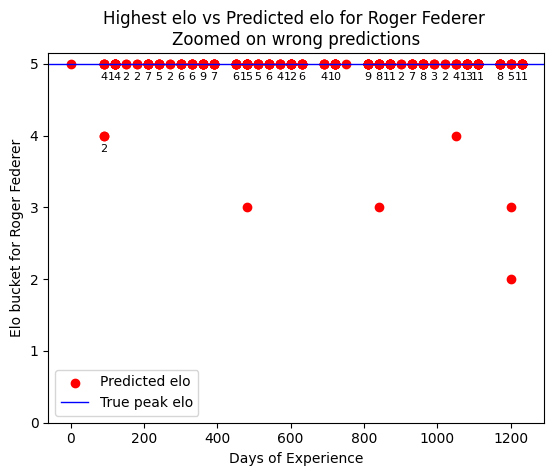

In [ ]:
if excluded_player:
    
    # Percentage of correctly predicted max elo
    guessed_correctly = (y_pred_player_excluded == y_test_player_excluded).mean()
    print(f"Percentage of players correctly guessed for a particular player (Accuracy): {guessed_correctly}")

    # confusion matrix for the player
    cm_xp = confusion_matrix(
    y_test_player_excluded, 
    y_pred_player_excluded, 
    labels=list(range(len(bin_labels)))  # ensures 0,1,2,3,4,5 all appear
    )

    plt.figure(figsize=(8,6))
    sns.heatmap(cm_xp, annot=True, fmt="d", cmap="Blues",xticklabels=bin_labels,yticklabels=bin_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {name_chosen_player}")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

    # create a dataframe of the results
    excluded_player_results = pd.DataFrame({
        'predicted_peak_elo_encoded':y_pred_player_excluded,
        'true_peak_elo_encoded':y_test_player_excluded,
        'correctly_predicted':y_pred_player_excluded==y_test_player_excluded
        })
    # merge the results with the x too get a full view and be able to visualise it
    excluded_player_final = pd.concat([X_player_excluded,excluded_player_results],axis=1)

    lower_bounds = [int(label.split('-')[0]) for label in bin_labels]
    upper_bounds = [int(label.split('-')[1]) for label in bin_labels]

    # Create a lookup dictionary from encoded bin -> bound
    lower_dict = dict(enumerate(lower_bounds))
    upper_dict = dict(enumerate(upper_bounds))

    # Add new columns directly
    excluded_player_final['predicted_lower'] = excluded_player_final['predicted_peak_elo_encoded'].map(lower_dict)
    excluded_player_final['predicted_upper'] = excluded_player_final['predicted_peak_elo_encoded'].map(upper_dict)

    excluded_player_final['true_lower'] = excluded_player_final['true_peak_elo_encoded'].map(lower_dict)
    excluded_player_final['true_upper'] = excluded_player_final['true_peak_elo_encoded'].map(upper_dict)

    # bin the days of experience to reduce the data points on the graph
    excluded_player_final['days_bin'] = (excluded_player_final['days_of_experience'] // 30) * 30

    # show predicted vs true as labled values (easier to look at than ranks)
    plt.scatter(excluded_player_final['days_bin'], excluded_player_final['predicted_peak_elo_encoded'], color='red', label='Predicted elo')
    plt.plot(excluded_player_final['days_bin'], excluded_player_final['true_peak_elo_encoded'], color='blue', label='True elo')
    plt.xlabel('Days of Experience')
    plt.ylabel(f'Elo bucket for {name_chosen_player}')
    plt.title(f'Highest elo bucket vs predicted elo for {name_chosen_player}')
    plt.legend()
    # make sure that the ticks are full integers
    ax = plt.gca()
    ax.set_yticks([0,1,2,3,4,5])
    ax.set_yticklabels([0,1,2,3,4,5])
    plt.show()

    # get the last value from days bin where the pred was wrong
    last_wrong_pred_day_plus_30 = excluded_player_final[excluded_player_final['correctly_predicted'] == 0][['days_bin']].iloc[-1,0]+30
    zoomed_excluded_player_df = excluded_player_final[excluded_player_final['days_bin'] <= last_wrong_pred_day_plus_30]
    
    # 
    df = zoomed_excluded_player_df[['days_bin', 'predicted_peak_elo_encoded']].copy()
    counts = df.groupby(['days_bin', 'predicted_peak_elo_encoded']).size().reset_index(name='count')

    plt.xlabel('Days of Experience')
    plt.ylabel(f'Elo bucket for {name_chosen_player}')
    plt.title(f'Highest elo vs Predicted elo for {name_chosen_player} \nZoomed on wrong predictions')
    plt.scatter(zoomed_excluded_player_df['days_bin'], zoomed_excluded_player_df['predicted_peak_elo_encoded'],color='red',label='Predicted elo')
    plt.axhline(y=zoomed_excluded_player_df['true_peak_elo_encoded'].iloc[-1], color='blue', linestyle='-', linewidth=1, label='True peak elo')

    # create labels for places where points overlap
    for _, row in counts.iterrows():
        if row['count'] > 1:
            plt.text(row['days_bin'], row['predicted_peak_elo_encoded']-0.18, str(row['count']),
                    fontsize=8, ha='center', va='center')

    # make sure that the ticks are full integers
    ax = plt.gca()
    ax.set_yticks([0,1,2,3,4,5])
    ax.set_yticklabels([0,1,2,3,4,5])
    plt.legend()
    plt.show()